# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [56]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
import time

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
azdias.shape

(891221, 367)

In [4]:
customers.shape

(191652, 370)

In [5]:
sum(customers[customers.columns[25]].isna())

3213

In [6]:
def show_types_nans(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    df_types - (pandas dataframe) dataframe with details about df columns, column types and the sum of NaNs in this column.
    
    '''
    cols = []
    types = []
    nans = []
    n = len(df.columns)
    for i in range(0, n):
        cols.append(df.columns[i])
        types.append(df[df.columns[i]].dtype)
        nans.append(sum(df[df.columns[i]].isna()))

    df_types = pd.DataFrame({'column_name': cols,
                            'd_types': types,
                            '#_nans': nans}) 
    return df_types

In [7]:
df_types = show_types_nans(customers)
df_types.head()

,column_name,d_types,#_nans
0,Unnamed: 0,int64,0
1,LNR,int64,0
2,AGER_TYP,int64,0
3,AKT_DAT_KL,float64,46596
4,ALTER_HH,float64,46596


In [8]:
df_types[df_types['d_types'] == object]

,column_name,d_types,#_nans
18,CAMEO_DEU_2015,object,50428
19,CAMEO_DEUG_2015,object,50428
20,CAMEO_INTL_2015,object,50428
62,D19_LETZTER_KAUF_BRANCHE,object,47697
98,EINGEFUEGT_AM,object,49927
318,OST_WEST_KZ,object,49927
365,PRODUCT_GROUP,object,0
366,CUSTOMER_GROUP,object,0


> First, I will have a closer look at all string columns as they are not suitable for machine learning algorithms.

In [9]:
customers['CAMEO_DEU_2015'].value_counts()

2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

In [10]:
customers['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [11]:
customers['CAMEO_INTL_2015'].value_counts()

14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

> The columns 'CAMEO_INTL_2015' and 'CAMEO_DEUG_2015' contain floats, integers and strings (value: XX). The value XX is not in the value list provided by the overview sheet. It is assumed that the records with value XX have an unknown entry and will be therefore changed to -1.

In [12]:
customers['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_REST           3619
D19_BANKEN_DIREKT          3466
D19_LEBENSMITTEL           3053
D19_TELKO_REST             2303
D19_NAHRUNGSERGAENZUNG     2253
D19_TELKO_MOBILE           2131
D19_TECHNIK                1836
D19_BANKEN_GROSS           1684
D19_FREIZEIT               1672
D19_SAMMELARTIKEL          1610
D19_RATGEBER               1519
D19_KINDERARTIKEL          1439
D19_WEIN_FEINKOST          1424
D19_BANKEN_REST            1233
D19_BIO_OEKO                808
D19_REISEN                  666
D19_DIGIT_SERV              653
D19_GARTEN                  568
D19_HANDWERK                532
D19_BILDUNG                 357
D19_TIER

In [13]:
customers['EINGEFUEGT_AM'].value_counts()

1992-02-10 00:00:00    64744
1992-02-12 00:00:00    43686
2003-11-18 00:00:00     1066
2005-12-16 00:00:00      808
1995-02-07 00:00:00      569
2004-04-14 00:00:00      443
2005-08-23 00:00:00      391
2005-04-15 00:00:00      363
1993-03-01 00:00:00      357
1995-10-10 00:00:00      317
2000-05-10 00:00:00      315
1992-02-21 00:00:00      304
1993-09-21 00:00:00      294
1993-10-21 00:00:00      287
1993-09-22 00:00:00      231
1995-07-19 00:00:00      209
2005-04-12 00:00:00      200
1993-11-03 00:00:00      193
1995-08-02 00:00:00      189
1996-01-26 00:00:00      187
1993-11-02 00:00:00      181
1995-08-15 00:00:00      180
1995-10-17 00:00:00      179
1993-09-23 00:00:00      177
1993-01-20 00:00:00      166
1993-03-23 00:00:00      159
1993-10-25 00:00:00      152
1995-12-27 00:00:00      149
1995-09-06 00:00:00      148
2004-10-14 00:00:00      147
2006-01-19 00:00:00      143
1996-03-04 00:00:00      133
1996-02-29 00:00:00      132
1995-10-18 00:00:00      128
1993-09-28 00:

In [14]:
sum(customers['EINGEFUEGT_AM'].isna())

49927

In [15]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [16]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [17]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [18]:
cols = []
no_values = []
for i in range(0, 370):
    cols.append(customers.columns[i])
    no_values.append(sum(customers[customers.columns[i]].isna())/len(customers))

dictionary_na = dict(zip(cols, no_values))
na_values = pd.DataFrame.from_dict(dictionary_na, orient = 'index')

C:\Users\q407073\AppData\Local\Temp/ipykernel_4992/3051411549.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show();


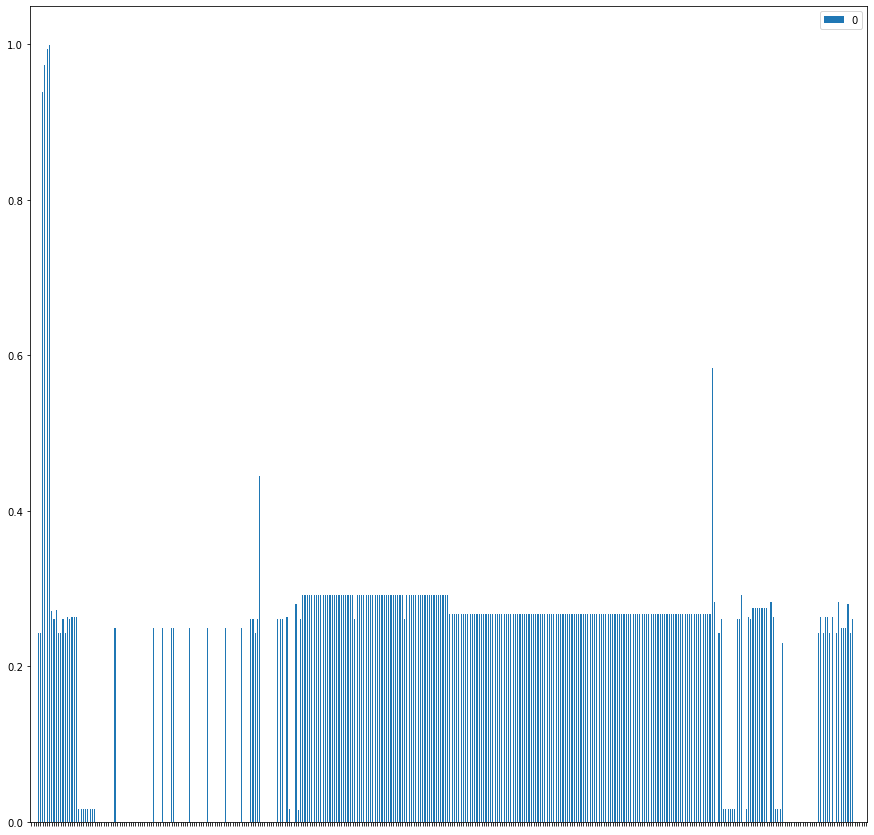

In [19]:
subplot = na_values.plot.bar(figsize=(15,15))
ax = subplot.axes
ax.set_xticklabels([])
f = ax.get_figure()
f.show();

> There are a few columns with a lot of missing values in the customer dataframe. All columns with more than 40% of missing values will be evaluated if they are needed for further analysis.

In [20]:
na_values[na_values[0]>0.4]

,0
ALTER_KIND1,0.938607
ALTER_KIND2,0.973389
ALTER_KIND3,0.993347
ALTER_KIND4,0.998769
EXTSEL992,0.444989
KK_KUNDENTYP,0.584064


> The columns regarding the childrens as well as the "EXTSEL992"-column will be deleted. The column "KK_KUNDENTYP" will be kept first and further analysed. All other columns with missing values get replacements. According to the DIAS Value Attributes, most columns take the value -1 for "unknown". Exceptions are: ALTER_HH, CJT_GESAMTTYP and RETOURTYP_BK_S. These columns have the value "0" attributed with "unkown".

In [21]:
def data_cleaning(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    full_df - (pandas dataframe) cleaned dataframe where NaNs and X/XX were replaced by 0 or -1 according to the
        azdias information. All numeric columns have been cleaned and converted to integers.
    
    '''
    df_new = df.copy()
    df_new['CAMEO_INTL_2015'].replace('XX', -1, inplace=True)
    df_new['CAMEO_DEUG_2015'].replace('X', -1, inplace=True)
    df_new.drop(columns = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992'], inplace = True)
    df_new['ALTER_HH'].fillna(0, inplace = True)
    df_new['CJT_GESAMTTYP'].fillna(0, inplace =True)
    df_new['RETOURTYP_BK_S'].fillna(0, inplace = True)
    if 'D19_LETZTER_KAUF_BRANCHE' in df_new.columns:
        df_new['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT', inplace = True)
    df_new['EINGEFUEGT_AM'] = pd.to_datetime(df_new['EINGEFUEGT_AM'], errors = 'coerce')
    df_new.fillna(-1, inplace = True)
    df_no_numeric = df_new.loc[:, df_new.columns.isin(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 
                       'PRODUCT_GROUP', 'CUSTOMER_GROUP'])]
    df_numeric = df_new.copy().drop(columns = df_no_numeric.columns)
    df_numeric = df_numeric.astype('int64')
    full_df = pd.concat([df_no_numeric, df_numeric], axis = 1)
    return full_df
    

In [22]:
azdias.shape

(891221, 367)

In [23]:
azdias_clean = data_cleaning(azdias)

In [24]:
azdias_clean.shape

(891221, 362)

In [25]:
df_types_clean = show_types_nans(azdias_clean)
df_types_clean['d_types'].value_counts()

int64     358
object      4
Name: d_types, dtype: int64

In [26]:
customers_clean = data_cleaning(customers)

In [27]:
customers_clean.shape

(191652, 365)

In [28]:
df_types_c_clean = show_types_nans(customers_clean)
df_types_c_clean['d_types'].value_counts()

int64     359
object      6
Name: d_types, dtype: int64

In [29]:
azdias_clean.drop(columns = ['Unnamed: 0'], inplace = True)

In [30]:
customers_clean.drop(columns = ['Unnamed: 0'], inplace = True)

In [31]:
azdias_clean.to_csv('CLEAN_Udacity_AZDIAS_052018.csv', index = False)
customers_clean.to_csv('CLEAN_Udacity_CUSTOMERS_052018.csv', index = False)

> The cleaned datasets have been saved before joining and feature selection in order to skip the cleaning steps in the further work-process.

In [32]:
azdias_clean = pd.read_csv('CLEAN_Udacity_AZDIAS_052018.csv')
azdias_clean.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_M

In [33]:
customers_clean = pd.read_csv('CLEAN_Udacity_CUSTOMERS_052018.csv')
customers_clean.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13

> First, I will check the dataset regarding people occuring in the azdias dataset as well as in the customers dataset.

In [34]:
people_azdias = list(azdias_clean['LNR'])
len(people_azdias)

891221

In [35]:
people_customer = list(customers_clean['LNR'])
people_azdias.extend(people_customer)

In [36]:
people_df = pd.DataFrame.from_dict(people_azdias)
people_df = people_df.rename(columns={0: 'LNR'})

In [37]:
people_df[people_df.duplicated() == True]

,LNR


> Assuming each person has a unique LNR-id, there are no duplicated people in the azdias and customers dataset. Therefore, the two datasets can be merged without the risk of duplicated people.
> Before the merge, all people in the customers dataset will be marked as "customers" by a 1 in a new created column "customer" whereas all azdias people get market with 0 in the "customer" column.

In [38]:
customers_clean['customer'] = 1
customers_clean.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13

In [39]:
azdias_clean['customer'] = 0
azdias_clean.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_M

In [40]:
df = pd.concat([azdias_clean, customers_clean])
df = df.reset_index(drop=True)

In [41]:
df.shape

(1082873, 365)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

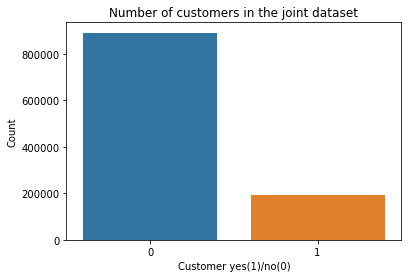

In [42]:
ax = sns.countplot(x='customer', data=df)
ax.set_title("Number of customers in the joint dataset")
ax.set_xlabel("Customer yes(1)/no(0)")
ax.set_ylabel("Count");

> There are only a few customers in the combined dataset. This should be considered in the Machine Leaning Algorithm to avoid overfitting.

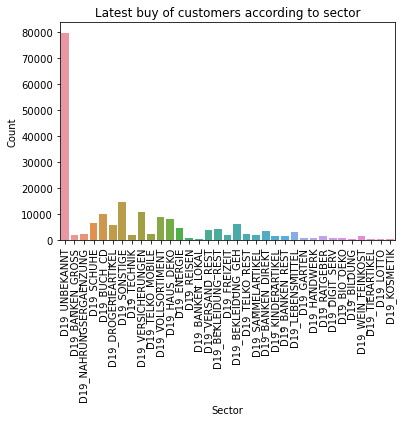

In [43]:
ax = sns.countplot(x='D19_LETZTER_KAUF_BRANCHE', data=customers_clean)
ax.set_title("Latest buy of customers according to sector")
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Sector")
ax.set_ylabel("Count");

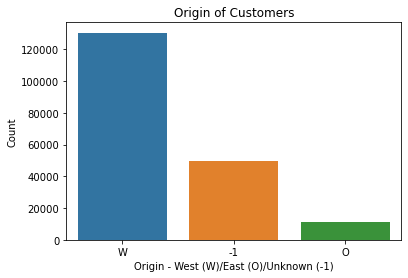

In [44]:
ax = sns.countplot(x='OST_WEST_KZ', data=customers_clean)
ax.set_title("Origin of Customers")
ax.tick_params(axis='x')
ax.set_xlabel("Origin - West (W)/East (O)/Unknown (-1)")
ax.set_ylabel("Count");

> In order to take the column "OST_WEST_KZ" into the Machine Leaning Model, the column will be encoded in the joint dataset. West = 1, East = 0, Unknown = -1

In [45]:
df['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace = True)
df['OST_WEST_KZ'].value_counts()

1     759910
0     179888
-1    143075
Name: OST_WEST_KZ, dtype: int64

> Next, the unsupervised machine learning algorithm will be created in order to learn about the similarities and differences between the population and the customer group.

In [60]:
y = df['customer']
X = df.copy()
X.drop(columns = ['customer', 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 
                  'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'LNR'], inplace = True)

In [61]:
X_info = show_types_nans(X)
X_info['#_nans'].value_counts()

0    357
Name: #_nans, dtype: int64

> First, we will try out a RandomForestClassifier to determine the Feature importance for the typology of the customers.

In [62]:
rfc = RandomForestClassifier(random_state=1234, class_weight = 'balanced')
rfc_model = rfc.fit(X, y)

-> Classificationsproblem: Ist Nutzer / ist kein Nutzer als Target (0/1), kann gewichtet werden!, dann RFC oder anderen Forest trainieren. -> Bäumchen geben Features importance -> unsere standardisierten Kunden entsprechen "dem hier" Alter: Wert 0.5, etc. 

In [63]:
start_time = time.time()
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.717 seconds


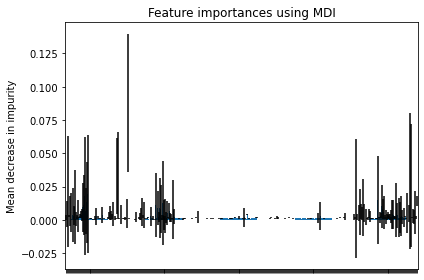

In [64]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels([])
fig.tight_layout();

In [65]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X,y)
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)

68

In [66]:
print(selected_feat)

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4',
       'CJT_TYP_5', 'CJT_TYP_6', 'D19_BUCH_CD', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_KONSUMTYP',
       'D19_KONSUMTYP_MAX', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'EINGEZOGENAM_HH_JAHR', 'FINANZ_ANLEGER',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'GEBURTSJAHR',
       'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KBA13_ANZAHL_PKW',
       'KOMBIALTER', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ONLINE_AFFINITAET',
       'PRAEGENDE_JUGEND

In [50]:
clf = DecisionTreeClassifier(random_state=1234, class_weight = 'balanced')
clf_model = clf.fit(X, y)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')